In [1]:
# Load data files
library(tidyverse)

# specify the directory where the files are located
source(here::here("lib/sources.R"))
dir_path <– TS_Master_selection

# obtain a list of file names in the directory
file_names <- list.files(path = dir_path, pattern = ".txt", full.names = TRUE)

# loop over each file and import the tables (use this for DATES)
for (file in file_names) {
  table_name <- gsub(".txt", "", basename(file)) # get the name of the table from the file name
  assign(table_name, read.table(file = file, header = FALSE, sep = "\t") %>%
           mutate(date = as.POSIXct(substr(V1, start = 24, stop = 36), format="%Y%m%d_%H%M", tz="UTC")))
}

Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4          v readr     2.1.5     
v forcats   1.0.0          v stringr   1.5.1     
v ggplot2   3.4.1          v tibble    3.2.1     
v lubridate 1.9.4          v tidyr     1.3.1.9000
v purrr     1.0.2          
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Match file name using DATE values
library(lubridate)

#dir_path2 <- "~/Library/CloudStorage/GoogleDrive-enriquemontes01@gmail.com/My Drive/GDrive/OCED_AOML/WS_cruises/plankton_imaging/CPICS/ws_cruise_ctd"
dir_path2 <– ws_cruise_ctd

file_name <- list.files(path = dir_path2, pattern = "ctd_meta_v4.csv", full.names = TRUE)
ctd_meta <- read.csv(file_name, fill = TRUE)

# USE WITH ctd_meta_v3.csv
dt_list <- as.POSIXct(paste(ctd_meta$year,
                            sprintf("%02d", ctd_meta$month),
                            sprintf("%02d", ctd_meta$day),
                            ctd_meta$time_gmt),
                      format = "%Y%m%d %I:%M:%S %p",
                      tz = "UTC")

################################################################################################################
# This section detects short transit times between stations

# Calculate time differences in seconds between consecutive dt_list objects
time_differences <- as.numeric(difftime(dt_list[-1], dt_list[-length(dt_list)], units = "secs"))

# Convert time differences from seconds to minutes
time_differences_mins <- time_differences / 60

# Create a data frame showing the original times and their differences in minutes
time_diff_df <- data.frame(
  start_time = dt_list[-length(dt_list)],
  end_time = dt_list[-1],
  time_difference_mins = time_differences_mins
)

# find CTD time stamps of consecutive stations within less than 20 min. This will identify CTD casts that are close to each other
short_t_idx <- which(time_diff_df$time_difference_mins < 20)
short_timestamps <- dt_list[short_t_idx]
#################################################################################################################

# Create empty data frame to store results
conc_occ_final <- data.frame(date = character(), count = numeric())

# List of class objects to be processed
class_names <- c("Acantharea", "Centric", "Ceratium", "Chaetoceros", "Chaetognaths", 
                 "Chain2", "Chain3", "Ostracods", "Copepods", "Decapods", "Echinoderms", 
                 "Guinardia", "Jellies", "Larvaceans", "Neocalyptrella", "Noctiluca", 
                 "pellets", "Polychaets", "Pteropods", "Tricho")

# time buffer before and after CTD time in seconds so that CPICS records are matched to CTD times.
start <- 10 * 60 
stop <- 10 * 60 

# Define the date limit
date_limit <- as.POSIXct("2024-09-30", tz = "UTC")

# Iterate over dt_list intervals
for (i in 1:length(dt_list)) {
  
  # Initialize a list to store counts for the current interval
  counts_list <- list(date = dt_list[i])
  
  # Iterate over each class object and perform subsetting
  for (class_name in class_names) {
    class_data <- get(paste0("class.", class_name))  # Dynamically get the class data frame
    
    # Filter out rows with dates after the date limit
    class_data <- subset(class_data, date <= date_limit)
    
    if (i < length(dt_list)) {
      # Subsetting for all intervals except the last one
      subset_data <- subset(class_data, date >= dt_list[i]-start & date < dt_list[i+1]-stop)
    } else {
      # Subsetting for the last interval: capture all data greater than or equal to the last dt_list
      subset_data <- subset(class_data, date >= dt_list[i]-start)
    }
    
    counts_list[[class_name]] <- nrow(subset_data)
  }
  
  # Convert counts_list to a data frame and bind it to the result
  result <- as.data.frame(counts_list)
  conc_occ_final <- rbind(conc_occ_final, result)
} 

# Combine with ctd_meta
taxa_meta <- cbind(ctd_meta, conc_occ_final)

################################################################################
# Check for unaccounted CPICS records 

# Initialize a list to store unaccounted dates for each class
unaccounted_dates_list <- list()

# Iterate over each class object
for (class_name in class_names) {
  # Get the date-time objects from the current class
  sel_class_dates <- get(paste0("class.", class_name))$date
  
  # Initialize a logical vector to track whether each class date is accounted for
  is_accounted_for <- rep(FALSE, length(sel_class_dates))
  
  # Check each class date against the intervals in dt_list
  for (i in 1:length(dt_list)) {
    if (i < length(dt_list)) {
      # Check all intervals except the last one
      interval_start <- dt_list[i] - start
      interval_end <- dt_list[i + 1] - stop
    } else {
      # Last interval captures all data greater than or equal to the last dt_list
      interval_start <- dt_list[i] - start
      interval_end <- date_limit  # Use date limit above
    }
    
    # Mark class dates that fall within the current interval as accounted for
    is_accounted_for <- is_accounted_for | (sel_class_dates >= interval_start & sel_class_dates < interval_end)
  }
  
  # Subset the class dates that were not accounted for
  unaccounted_sel_class_dates <- sel_class_dates[!is_accounted_for]
  
  # Store the unaccounted dates in the list
  unaccounted_dates_list[[class_name]] <- unaccounted_sel_class_dates
}

# Print or view the unaccounted dates for each class
for (class_name in class_names) {
  cat("Unaccounted dates for class:", class_name, "\n")
  print(unaccounted_dates_list[[class_name]])
  cat("\n")
}

Unaccounted dates for class: Acantharea 
POSIXct of length 0

Unaccounted dates for class: Centric 
 [1] "2024-11-10 01:28:00 UTC" "2024-11-10 01:28:00 UTC"
 [3] "2024-11-10 01:29:00 UTC" "2024-11-10 08:14:00 UTC"
 [5] "2024-11-10 10:37:00 UTC" "2024-11-10 10:38:00 UTC"
 [7] "2024-11-10 10:38:00 UTC" "2024-11-10 10:38:00 UTC"
 [9] "2024-11-10 10:38:00 UTC" "2024-11-10 10:38:00 UTC"
[11] "2024-11-10 10:39:00 UTC" "2024-11-10 10:39:00 UTC"
[13] "2024-11-10 10:39:00 UTC" "2024-11-10 10:39:00 UTC"
[15] "2024-11-10 10:39:00 UTC" "2024-11-10 10:40:00 UTC"
[17] "2024-11-10 10:40:00 UTC" "2024-11-10 10:40:00 UTC"
[19] "2024-11-10 10:40:00 UTC" "2024-11-10 10:40:00 UTC"
[21] "2024-11-10 10:40:00 UTC" "2024-11-10 10:40:00 UTC"
[23] "2024-11-10 10:40:00 UTC" "2024-11-10 10:41:00 UTC"
[25] "2024-11-10 10:41:00 UTC" "2024-11-10 10:41:00 UTC"
[27] "2024-11-10 10:41:00 UTC" "2024-11-10 11:00:00 UTC"
[29] "2024-11-10 11:01:00 UTC" "2024-11-10 11:01:00 UTC"
[31] "2024-11-10 11:02:00 UTC" "2024-11-10 15

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


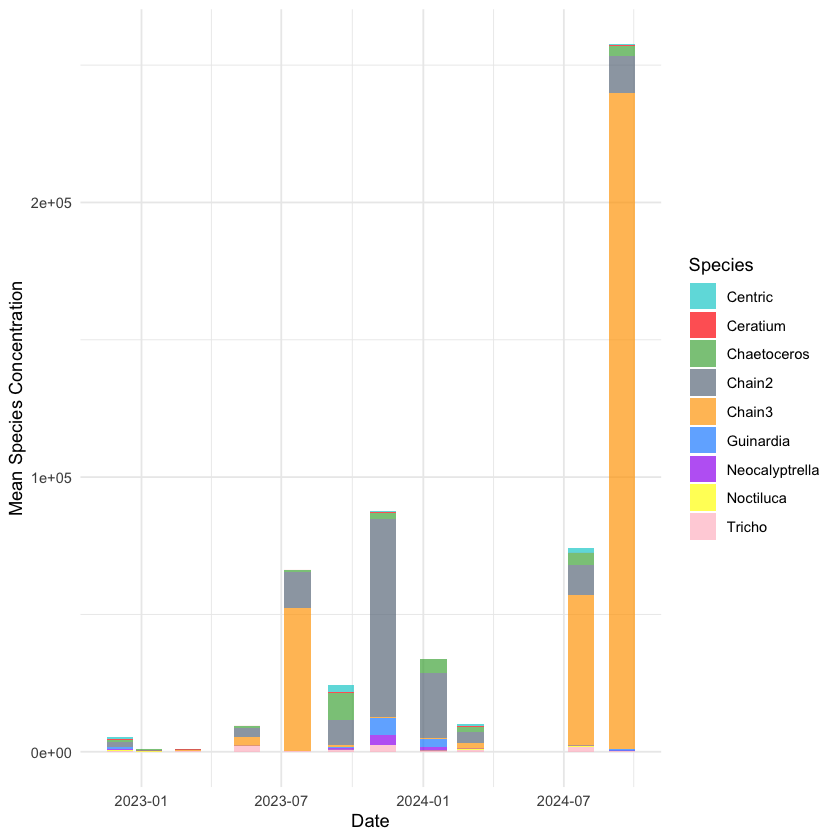

Notch went outside hinges
i Do you want `notch = FALSE`?


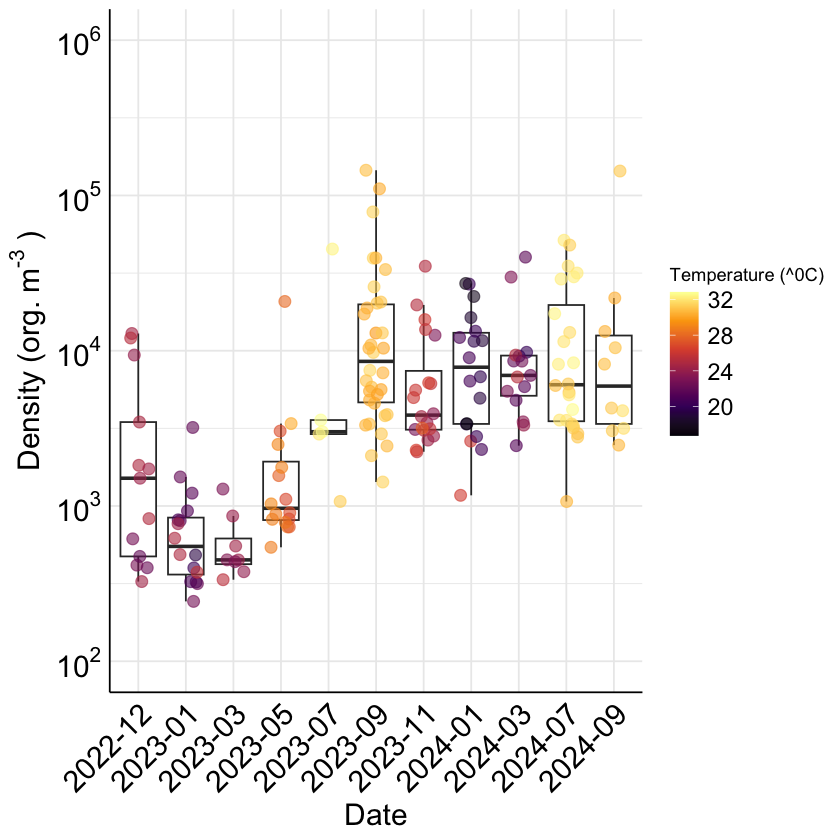

Notch went outside hinges
i Do you want `notch = FALSE`?


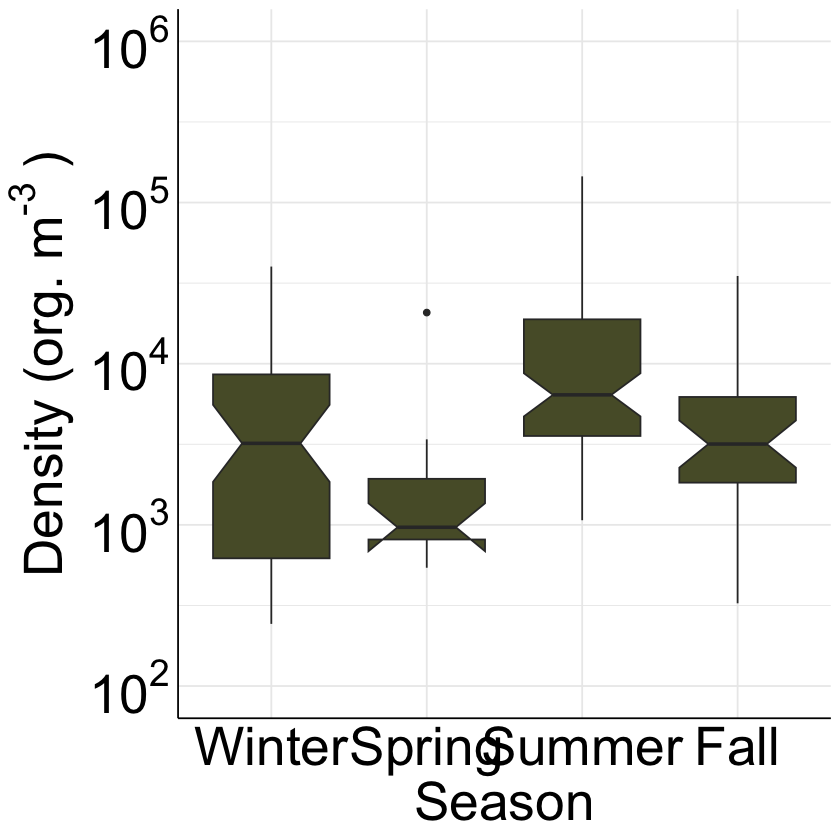

In [3]:
# Calculate species concentration (counts/ml) for each species

# # # For zooplankton
# taxa_meta_concentration <- taxa_meta %>%
#   mutate(across(c(Acantharea,Chaetognaths,Ostracods,Copepods,Decapods,Echinoderms,Jellies,
#     Larvaceans,Polychaets,Pteropods), ~ ./total_vol_sampled * 1e6)) %>%
#   select(Station, dec_lat, dec_lon, year, month, date, Avg.chl.a..ug.L.,
#          temp..degC., salinity, total_vol_sampled,
#          Acantharea,Chaetognaths,Ostracods,Copepods,Decapods,Echinoderms,
#          Jellies,Larvaceans,Polychaets,Pteropods) %>%
#   filter(!is.na(total_vol_sampled))
# 
# # # Transform taxa_meta_concentration to long format
# taxa_meta_long <- taxa_meta_concentration %>%
#   pivot_longer(cols = c(Acantharea, Chaetognaths,Ostracods,Copepods,Decapods,
#                         Echinoderms, Jellies, Larvaceans,Polychaets, Pteropods),
#                names_to = "species", values_to = "species_concentration")

# For phytoplankton
taxa_meta_concentration <- taxa_meta %>%
  mutate(across(c(Centric,Ceratium,Chaetoceros,Chain2,Chain3,Guinardia,Neocalyptrella,
                  Noctiluca,Tricho), ~ ./total_vol_sampled * 1e6)) %>%
  select(Station, dec_lat, dec_lon, year, month, date, Avg.chl.a..ug.L.,
         temp..degC., salinity,total_vol_sampled,
         Centric,Ceratium,Chaetoceros,Chain2,Chain3,Guinardia,Neocalyptrella,
                  Noctiluca,Tricho) %>%
  filter(!is.na(total_vol_sampled))

# # Transform taxa_meta_concentration to long format
taxa_meta_long <- taxa_meta_concentration %>%
  pivot_longer(cols = c(Centric,Ceratium,Chaetoceros,Chain2,Chain3,Guinardia,Neocalyptrella,
                  Noctiluca,Tricho),
               names_to = "species", values_to = "species_concentration")

# Filter the data for Stations
# station_list_fk <- c("WS","21/LK","MR","16","18","10","12","9.5","9","7","2")
# station_list_sr <- c("68","65","64","60","58","57.3","57.2","57.1","57","56","55","54","53","51",
#                   "49","47","45","41","30","31","33")
# station_list_cal <- c("CAL5","CAL4","CAL3","CAL2","CAL1","RP1","RP2","RP3","RP4","GP5","BG4","BG3",
#                   "BG2","BG1","BG6", "BG7")
# station_list_vl <- c("V1","V2","V3","V4","V5","V6","V7","V8","V9","L1","L3","L5","L7","L9")
# station_list_tb <- c("AMI9","AMI8","AMI7","AMI6","AMI5","AMI4","AMI3","AMI2","AMI1","TB1","TB2",
#                   "TB3","TB4","TB5","TB10","CW4","CW3","CW2","CW1")
# station_selected <- "WS"

# # station_list_per_isobath.csv is generated by the Matlab script sfer_sta_mapper.m (ws_cruises folder)
station_list_bathy <- read.csv("station_list_per_isobath.csv", fill = TRUE)
colnames(station_list_bathy) <- c("20m", "50m", "200m")
# Combine all stations from station_list_bathy into a single character vector
all_stations_bathy <- unique(unlist(station_list_bathy))
# Get the unique station names from taxa_meta
all_stations_taxa <- unique(taxa_meta$Station)
# Find stations in taxa_meta$Station not present in station_list_bathy 
stations_not_in_taxa <- setdiff(all_stations_taxa, all_stations_bathy)

# filter the data using station lists
# filtered_taxa_meta_long <- taxa_meta_long %>%
# filter(Station %in% station_list_bathy[, 2])

# # Without filtering per group of stations but looking at the entire region
filtered_taxa_meta_long <- taxa_meta_long

# Calculate mean and standard deviation of species concentration for each date
summary_data <- filtered_taxa_meta_long %>%
  group_by(year, month, species) %>%
  summarise(mean_concentration = mean(species_concentration, na.rm = TRUE),
            sd_concentration = sd(species_concentration, na.rm = TRUE),
            earliest_day = min(as.numeric(format(date, "%d")), na.rm = TRUE)) %>%
  ungroup()

# Combine year and month columns into a single date column
summary_data$date <- as.Date(paste(summary_data$year, summary_data$month, summary_data$earliest_day, sep = "-")) 

# custom_pal_hex2 <- c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf')
custom_pal_hex2 <- c('darkturquoise','red','#4daf4a','slategray4','orange','dodgerblue','purple', "yellow","pink","violet")

# Acantharea = darkturquoise
# Copepods = red
# echinos = #4daf4a
# Jellies = slategray4
# Larvaceans = orange
# Polychaetes = dodgerblue
# Pteropods = purple

# # Check dominance of groups by calculating the overall mean 
# test <- summary_data %>% filter(species == "Polychaetes") %>% summarize(avg = mean(mean_concentration))
# mean(test$avg)

# Plot time series of mean+sd planton concentration per group of sites
zz <- ggplot(summary_data, aes(x = date, y = mean_concentration, fill = species)) +
  geom_bar(stat = "identity", alpha = 0.7) +
  scale_fill_manual(values = custom_pal_hex2) +
  # geom_errorbar(aes(ymin = 0, ymax = mean_concentration + sd_concentration),
  #               position = position_dodge(width = 0.9), width = 0.2) +
  labs(x = "Date", y = "Mean Species Concentration", fill = "Species") +
  theme_minimal()
zz

# Filter summary_data for selected only
# Acantharea, Copepods, Echinoderms, Jellies, Larvaceans, Chaetognaths, Polychaets, Pteropods
# Centric,Ceratium,Chaetoceros,Chain2,Chain3,Guinardia,Neocalyptrella,Noctiluca,Tricho

selected_group <- "Chaetoceros"

summary_selected <- filtered_taxa_meta_long %>%
  filter(species == selected_group) %>%
  filter(species_concentration > 0) %>%
  group_by(year, month) %>%
  mutate(earliest_day = min(as.numeric(format(date, "%d")), na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(date = as.Date(paste(year, month, earliest_day, sep = "-"))) %>%
  select(-earliest_day)  # Optionally, remove the 'earliest_day' column if not needed

# Create a vector of date labels
unique_dates <- sort(unique(summary_selected$date))  # Get unique dates
unique_dates <- format(unique_dates, "%Y-%m")
custom_date_labels <- as.character(unique_dates)

# Create the time series boxplot
  sel_box <-  ggplot(summary_selected, aes(x = as.factor(date), y = species_concentration)) +
    geom_boxplot(fill = "white", notch = FALSE, outlier.shape = NA) +
    # geom_violin(fill = "lightgrey", color = "NA", alpha = 0.7) +
    # geom_jitter(aes(color = factor(Station), size = temp..degC.), alpha = 0.9) +
    # geom_jitter(width = 0.25, aes(color = temp..degC., size = salinity), alpha = 0.6) + # with salinity included
    geom_jitter(width = 0.25, aes(color = temp..degC.), size = 3, alpha = 0.6) +
    labs(x = "Date", y = expression("Density (org. m"^"-3"~")")) +
    scale_color_viridis_c(name = "Temperature (°C)", option = "inferno") +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x)), limits = c(1e2, 1e6)) +
    # scale_size_continuous(name = "Salinity", # with salinity included
    #                       limits = c(30, 38),
    #                       breaks = c(30, 32, 34, 36, 38),
    #                       range = c(1, 4)) +
    scale_x_discrete(labels = custom_date_labels) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 18, color = "black"),  # Set X-axis label font size
          axis.text.y = element_text(size = 18, color = "black")) +
    theme(axis.title.x = element_text(size = 18, color = "black"),
          axis.title.y = element_text(size = 18, color = "black")) +
    theme(legend.text = element_text(size = 14)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme(axis.line = element_line(color = "black")) 
  sel_box

sel_bar <- ggplot(summary_selected, aes(x = as.factor(date), y = species_concentration)) +
  geom_bar(stat = "identity", alpha = 0.8, width = 0.4) +
  labs(title = "Total Copepod Density at Site WS",
       x = "Date",
       y = expression("Total ind. m"^"-3")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  
# Save figure as a svg file  
ggsave(paste0("conc_time-series_1-50m_", selected_group, ".svg"), plot = sel_box, width = 10, height = 8, device = "svg")

# # Create seasonal boxplots
# Step 1: Define seasons based on the month column
summary_selected <- summary_selected %>%
  mutate(season = case_when(
    month %in% c(1, 2, 3) ~ "Winter",
    month %in% c(4, 5, 6) ~ "Spring",
    month %in% c(7, 8, 9) ~ "Summer",
    month %in% c(10, 11, 12) ~ "Fall"
  ))

# Step 2: Convert season to a factor with specified order
summary_selected$season <- factor(summary_selected$season, levels = c("Winter", "Spring", "Summer", "Fall"))

# color order zooplankton: 1: Rhizaria spp, 2: Chaetognaths, 3: Copepods, 4: Decapods, 5: Echinoderms, 6: Gelatinous, 7: Larvaceans, 8: Ostracods, 9: Polychaetes, 10: Pteropods
# color order phytoplankton: 1: Coscinodiscus, 2: Neoceratium, 3: Chaetoceros, 4: Chain diatoms, 5: Skeletonema , 6: Guinardia striata, 7: Neocalyptrella, 8: Hemidiscus, 9: Trichodesmium

spp_colors_zoopl <- c("#551F00FF", "#889D35FF", "#DF7700FF", "#F5B642FF","#FFF179FF","#C3F4F6FF", "#6AD5E8FF", "#32B2DAFF", "#7992A6FF", "#C0D1CEFF")
spp_colors_phyto <- c("#B4B87FFF", "#9C913FFF", "#585B33FF", "#6EA8ABFF", "#397893FF", "#31333FFF", "#8F5715FF", "#BA9A44FF", "#CFBB83FF")

# Step 3: Create the box plot
  season_boxplot <- ggplot(summary_selected, aes(x = season, y = species_concentration)) +
    geom_boxplot(fill = spp_colors_phyto[3], notch = TRUE) +
    labs(x = "Season", y = expression("Density (org. m"^"-3"~")")) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x)), limits = c(1e2, 1e6)) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 32, color = "black"),
          axis.title = element_text(size = 32, color = "black"),
          axis.text.y = element_text(size = 32, color = "black")) +
    theme(axis.line = element_line(color = "black")) 
  season_boxplot
  
# Save figure as a svg file  
ggsave(paste0("boxplot_seasonal_", selected_group, ".svg"), plot = season_boxplot, width = 10, height = 8, device = "svg")
  
# # Plot concentration time series for all selected sites
# kk <- ggplot(summary_selected, aes(x = date, y = species_concentration, shape = factor(Station))) +
#   labs(x = "Date", y = "Species concentration (org.m-3)") +
#   geom_point(aes(size = temp..degC.), fill = "darkgrey") + # or colour = factor(Station)
#   scale_shape_manual(values = c(0, 1, 2, 3, 4, 5, 6))
# kk

# kk <- ggplot(summary_selected, aes(x = date, y = species_concentration, colour = factor(Station))) +
#   labs(x = "Date", y = "Species concentration (org.m-3)") +
#   geom_point(aes(size = temp..degC.), alpha = 0.7) + # or colour = factor(Station) +
#   # geom_smooth(method = "lm", formula = y ~ poly(x, 4), se = FALSE) + # Add polynomial fit line
#   scale_colour_brewer(palette = "Set1")
# kk
  
# # Find the index of the last row with date == '2023-01-15' and add a dummy row for missing dates
# new_row <- tibble(Station = NA, dec_lat = NA, dec_lon = NA, year = NA,
#                   month = NA, date = as.Date('2023-03-15'), Avg.chl.a..ug.L. = NA,
#                   temp..degC. = NA, salinity = NA, species = NA, species_concentration = NA)
# last_index <- max(which(summary_selected$date == as.Date('2023-01-15')))
# summary_selected <- bind_rows(
#     summary_selected[1:last_index, ],
#     new_row,
#     summary_selected[(last_index + 1):nrow(summary_selected), ]
#   )

Warning message:
"package 'paletteer' was built under R version 4.2.3"
`summarise()` has grouped output by 'X8.day.seascapes'. You can override using
the `.groups` argument.


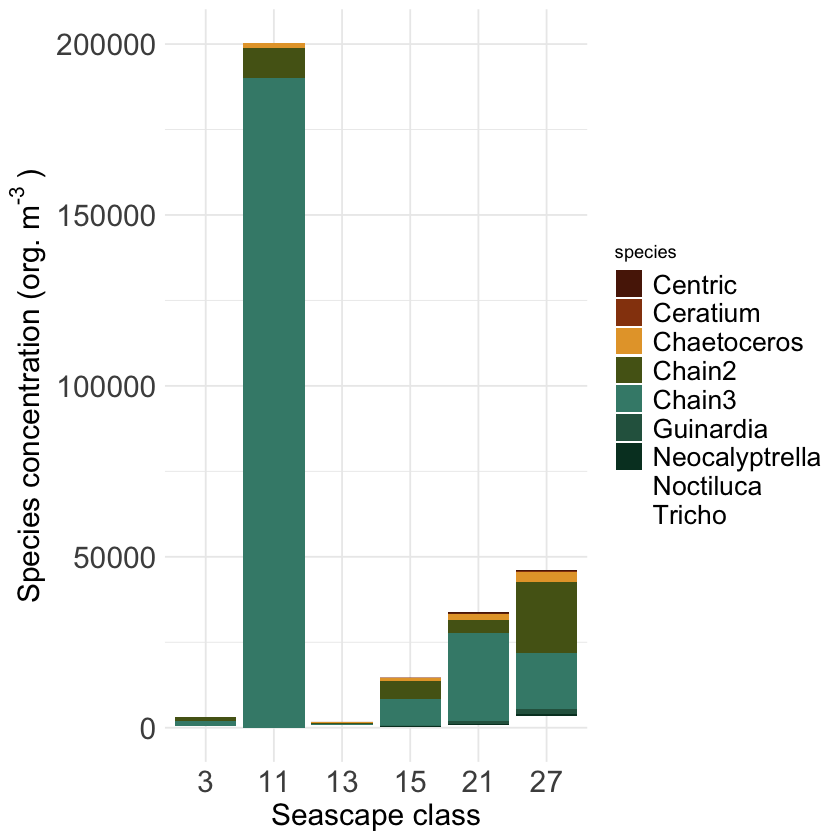

`summarise()` has grouped output by 'species'. You can override using the
`.groups` argument.


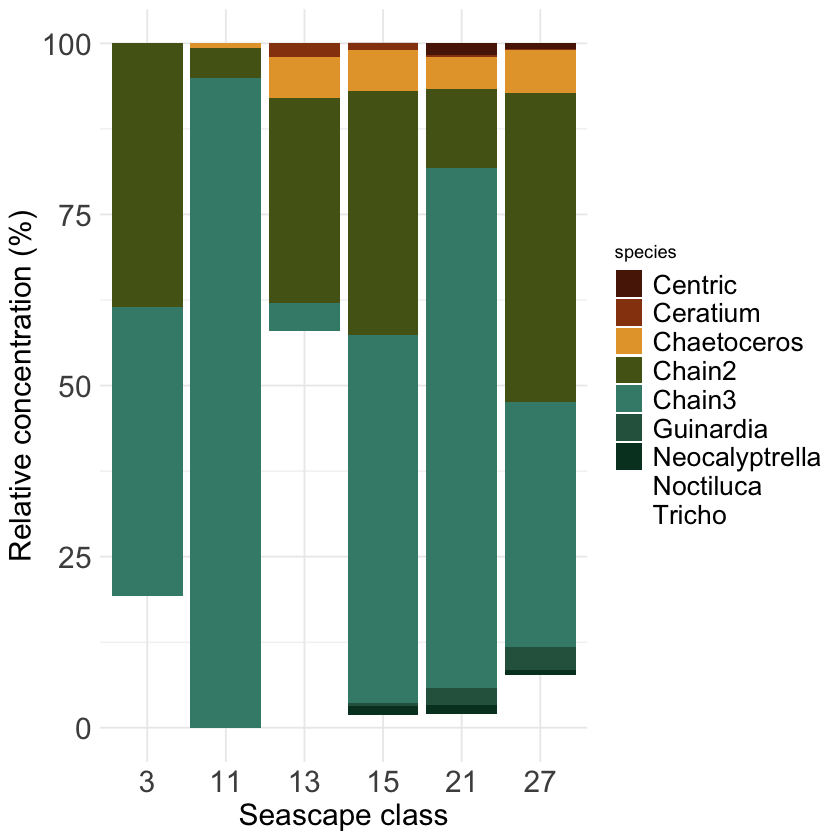

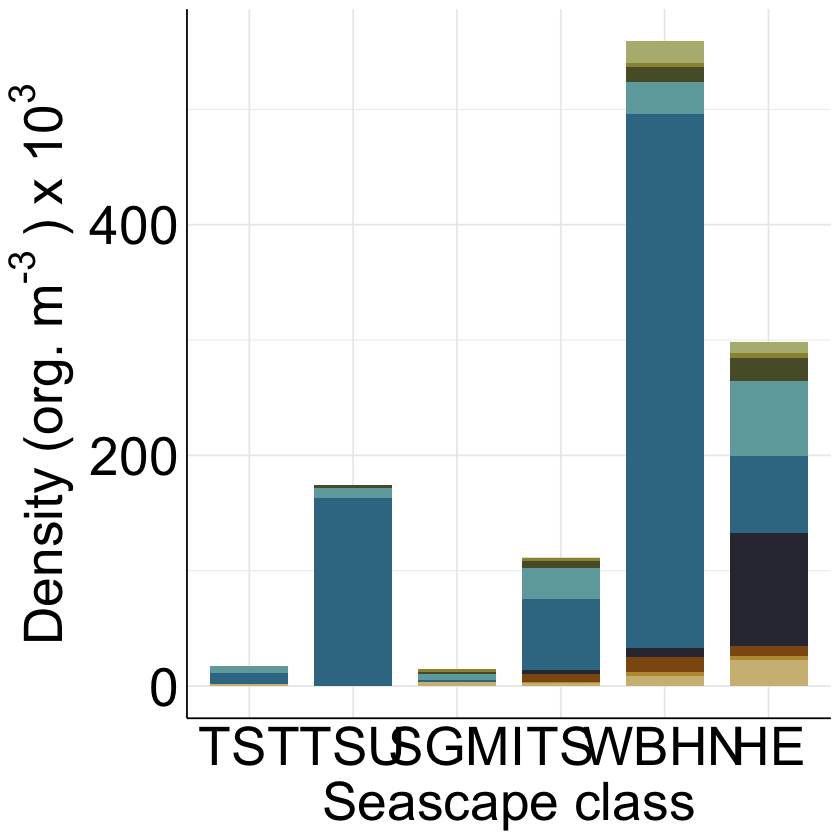

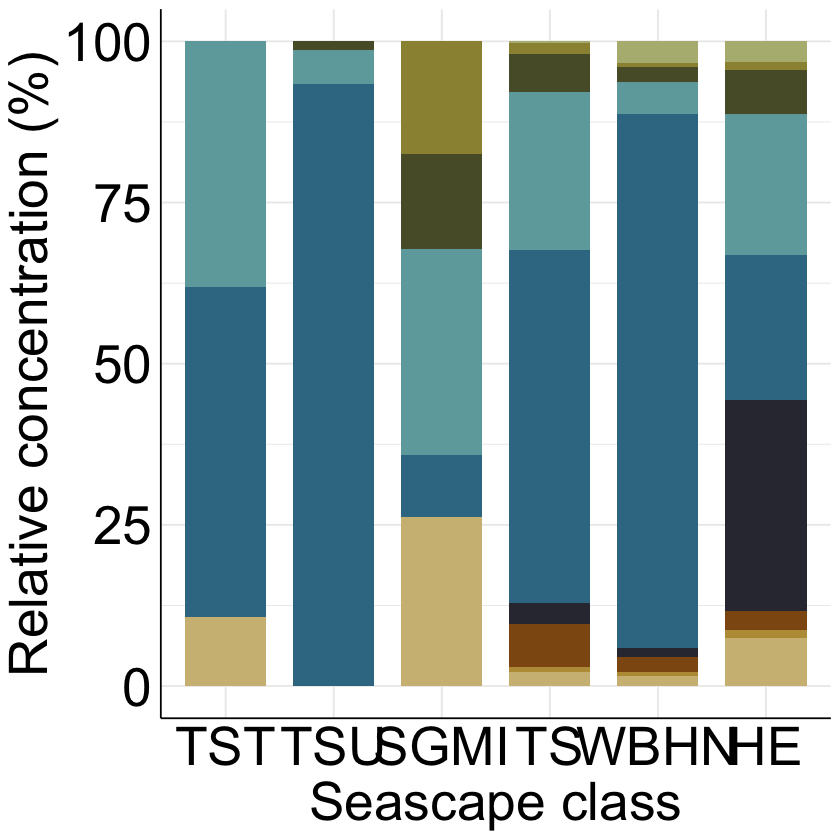

In [4]:
# # Calculate plankton concentrations per seascape class
library(paletteer)

# spp_df <- taxa_meta[ , c("X8.day.seascapes", "total_vol_sampled", "date",
#                          "Acantharea",
#                          "Chaetognaths",
#                          "Copepods",
#                          "Decapods",
#                          "Echinoderms",
#                          "Jellies",
#                          "Larvaceans",
#                          "Ostracods",
#                          "Polychaets",
#                          "Pteropods")]

spp_df <- taxa_meta[ , c("X8.day.seascapes", "total_vol_sampled", "date",
                         "Centric",
                         "Ceratium",
                         "Chaetoceros",
                         "Chain2",
                         "Chain3",
                         "Guinardia",
                         "Neocalyptrella",
                         "Noctiluca",
                         "Tricho")]

# Remove rows with NaN values in X8.day.seascapes and total_vol_sampled
spp_df <- subset(spp_df, !is.na(X8.day.seascapes) & !is.na(total_vol_sampled))

# Calculate total counts per species within each X8.day.seascapes category
spp_count_per_seascape <- spp_df %>%
  gather(key = "species", value = "count", -(X8.day.seascapes:date)) %>%
  group_by(X8.day.seascapes, species) %>%
  summarise(total_count = sum(count)) %>%
  ungroup()

# Calculate total volume sampled per X8.day.seascapes category
total_vol_per_seascape <- spp_df %>%
  group_by(X8.day.seascapes) %>%
  summarise(total_vol_sampled = sum(total_vol_sampled))

# Merge total counts and total volume data frames
spp_concentration <- merge(spp_count_per_seascape, total_vol_per_seascape, by = "X8.day.seascapes")

# Calculate species per cubic meter: might be misleading since it integrates all counts and sampled volumes across cruises to calculate concentrations. It is likely better to use average concentrations as below.
spp_concentration$species_per_cubic_meter <- spp_concentration$total_count / spp_concentration$total_vol_sampled * 1e6

# # Select desired seascapes and reorder categories in X axis
spp_concentration$X8.day.seascapes <- factor(spp_concentration$X8.day.seascapes, levels = c("3", "11", "13", "15","21","27"))

# Create the stack plot
concentration_stackplot <- ggplot(spp_concentration, aes(x = X8.day.seascapes, y = species_per_cubic_meter, fill = species)) +
  geom_bar(stat = "identity") +
  scale_fill_paletteer_d("MetBrewer::Degas") +
  labs(x = "Seascape class", y = "Species concentration (org. m"^"-3"~")") +
theme_minimal() +
  theme(axis.text.x = element_text(size = 18),  # Set X-axis label font size
        axis.text.y = element_text(size = 18)) +
  theme(axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18)) +
  theme(legend.text = element_text(size = 16))
concentration_stackplot

# Calculate percentages
spp_concentration_percent <- spp_concentration %>%
  group_by(X8.day.seascapes) %>%
  mutate(total_concentration = sum(species_per_cubic_meter),
         species_percentage = (species_per_cubic_meter / total_concentration) * 100)

# Create the stacked plot
concentration_percent_stackplot <- ggplot(spp_concentration_percent, aes(x = X8.day.seascapes, y = species_percentage, fill = species)) +
  geom_bar(stat = "identity") +
  scale_fill_paletteer_d("MetBrewer::Degas") +
  labs(x = "Seascape class", y = "Relative concentration (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(size = 18),  # Set X-axis label font size
        axis.text.y = element_text(size = 18)) +
  theme(axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18)) +
  theme(legend.text = element_text(size = 16))
concentration_percent_stackplot

# Gather columns containing species counts into key-value pairs and calculate concentrations
spp_concentration_long <- spp_df %>%
  gather(key = "species", value = "count", -(X8.day.seascapes:date)) %>%
  mutate(concentration = (count / total_vol_sampled) * 1e6)

# Calculate the mean concentration and its standard deviation per species and 8X.day.seascapes category. This is likely more representative since the approach will capture high concentration events (high counts in low volumes) that otherwise get filtered out when using an overall integrated sampled volume and total counts for the total concentration.
avg_concentration_per_class <- spp_concentration_long %>%
  filter(concentration > 0) %>%
  group_by(species, `X8.day.seascapes`) %>%
  summarize(
    mean_concentration = mean(concentration, na.rm = TRUE)/1000  # the 1000 term is for plotting simplicity
  )

avg_concentration_per_class$X8.day.seascapes <- factor(avg_concentration_per_class$X8.day.seascapes, levels = c("3", "11", "13", "15","21","27"))

seascape_labels = c("TST", "TSU", "SGMI", "TS", "WBHN", "HE")

# seascape classes: 
# 3:Tropical/Subtrop. Trans.| 5: Subtrop. Gyre Trans | 7: Temperate Trans | 11: Tropical/Subtrop. Upwelling | 13: Subtrop. Gyre Mesos. Influenced | 15: Tropical Seas | 21: Warm Bloom High Nutrients | 27: Hypersal. Eutrophic

font_size = 32
spp_labels_zoopl <- c("Rhizaria spp", "Chaetognaths", "Copepods", "Decapods", "Echinoderms", "Gelatinous", "Larvaceans", "Ostracods", "Polychaetes", "Pteropods")
spp_labels_phyto = c("Coscinodiscus spp", "Neoceratium spp", "Chaetoceros spp", "Chain diatoms", "Skeletonema spp", "Guinardia striata", "Neocalyptrella spp", "Hemidiscus spp", "Trichodesmium spp")
spp_colors_zoopl <- c("#551F00FF", "#889D35FF", "#DF7700FF", "#F5B642FF","#FFF179FF","#C3F4F6FF", "#6AD5E8FF", "#32B2DAFF", "#7992A6FF", "#C0D1CEFF")
spp_colors_phyto <- c("#B4B87FFF", "#9C913FFF", "#585B33FF", "#6EA8ABFF", "#397893FF", "#31333FFF", "#8F5715FF", "#BA9A44FF", "#CFBB83FF")
# spp_colors_phyto <- c("#C969A1FF", "#CE4441FF", "#EE8577FF", "#EB7926FF", "#FFBB44FF", "#859B6CFF", "#62929AFF", "#004F63FF", "#122451FF")

avg_stackplot <- ggplot(avg_concentration_per_class, aes(x = X8.day.seascapes, y = mean_concentration, fill = species)) +
  geom_bar(stat = "identity", width = 0.75) +
  # scale_fill_manual(values = spp_colors_zoopl,
  # labels = spp_labels_zoopl) +
  scale_fill_manual(values = spp_colors_phyto,
    labels = spp_labels_phyto) +
  # ylim(0, 600) +
  scale_x_discrete(labels = seascape_labels) +
  labs(x = "Seascape class", y = expression("Density (org. m"^"-3"~") × 10"^3)) +
  theme_minimal() +
  theme(axis.text.x = element_text(size = font_size, color = "black"),
    axis.title = element_text(size = font_size, color = "black"),
    axis.text.y = element_text(size = font_size, color = "black")) +
  theme(axis.line = element_line(color = "black")) +
  theme(legend.text = element_text(size = font_size)) +
  theme(legend.position = "none")
avg_stackplot

# ggsave("abund_zooplankton.svg", plot = avg_stackplot, width = 14, height = 8, device = "svg")

# Calculate percentages
avg_concentration_percent <- avg_concentration_per_class %>%
  group_by(`X8.day.seascapes`) %>%
  mutate(mean_concentration_percent = mean_concentration / sum(mean_concentration) * 100)

avg_percent_stackplot <- ggplot(avg_concentration_percent, aes(x = X8.day.seascapes, y = mean_concentration_percent, fill = species)) +
  geom_bar(stat = "identity", width = 0.75) +
  # scale_fill_manual(values = spp_colors_zoopl,
  # labels = spp_labels_zoopl) +
  scale_fill_manual(values = spp_colors_phyto,
    labels = spp_labels_phyto) +
  scale_x_discrete(labels = seascape_labels) +
  labs(x = "Seascape class", y = "Relative concentration (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(size = font_size, color = "black"),
    axis.title = element_text(size = font_size, color = "black"),
    axis.text.y = element_text(size = font_size, color = "black")) +
  theme(axis.line = element_line(color = "black")) +
  theme(legend.text = element_text(size = font_size)) +
  theme(legend.position = "none")
avg_percent_stackplot

# ggsave("abund_zooplankton_percent.svg", plot = avg_percent_stackplot, width = 14, height = 8, device = "svg")

# Palettes (https://r-graph-gallery.com/color-palette-finder):
# use for zooplankton (8 categories):
# scale_fill_paletteer_d("MoMAColors::Abbott")
# scale_fill_manual(values = custom_pal_hex2) 
# scale_fill_paletteer_d("MetBrewer::Homer1")
# scale_fill_paletteer_d("MoMAColors::Lupi")
# scale_fill_paletteer_d("MetBrewer::Nizami")
# scale_fill_paletteer_d("colorblindr::OkabeIto")
# Home1: #551F00FF, #A62F00FF, #DF7700FF, #F5B642FF, #FFF179FF, #C3F4F6FF, #6AD5E8FF, #32B2DAFF

# use for phytoplankton (7 categories):
# scale_colour_brewer(palette = "Set2") 
# scale_fill_paletteer_d("MetBrewer::Archambault") + # use for phytoplankton (Archambault, Austria)
# scale_fill_paletteer_d("Manu::Kea") 
# scale_fill_paletteer_d("ghibli::MononokeMedium")
# scale_fill_paletteer_d("NatParksPalettes::SmokyMtns")
# #42511AFF, #889D35FF, #D3D175FF, #B50200FF, #DA6C41FF, #7C6E66FF, #BCAFA6FF


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Loading required package: viridisLite

Warning message:
"Removed 250 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 250 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 250 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 250 rows containing missing values (`geom_point()`)."


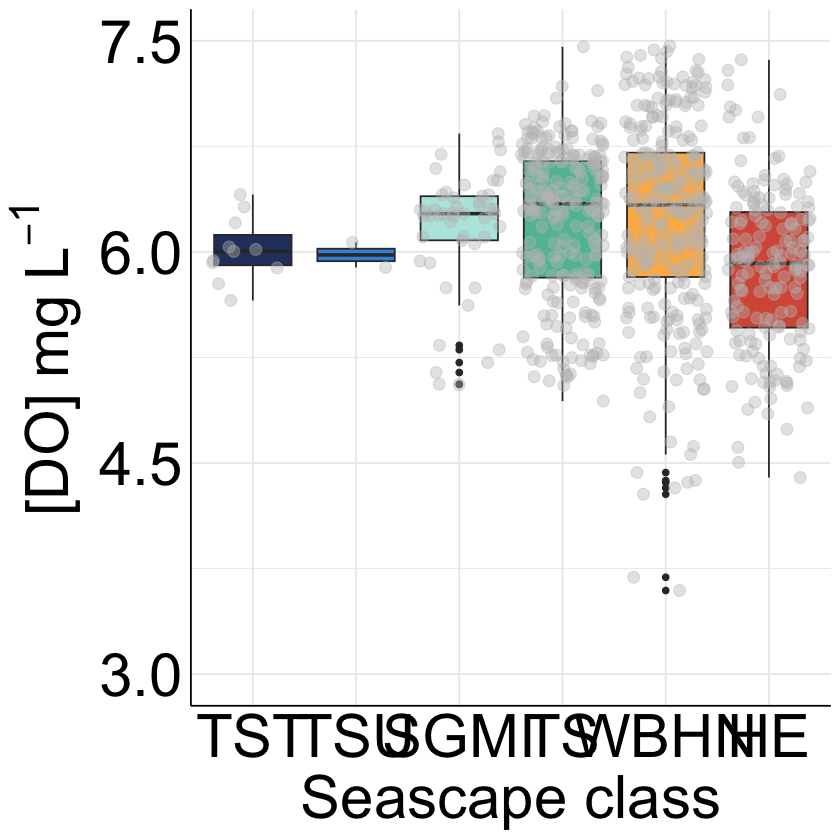

In [5]:
# # # Generate plots of parameter distributions per seascape class
library(hrbrthemes)
library(viridis)

# # Load seascape color palette used with Matlab and extract RGB values for observed unique seascapes
# For NOAA machines
# palette_dir <- "/Users/enrique.montes/Library/CloudStorage/GoogleDrive-enriquemontes01@gmail.com/My Drive/GDrive/software/matlab/m_map/seascape_cm"
# For personal machine
palette_dir <- "~/Library/CloudStorage/GoogleDrive-enriquemontes01@gmail.com/My Drive/GDrive/software/matlab/m_map/seascape_cm"
palette_file <- list.files(path = palette_dir, pattern = "cmap1.csv", full.names = TRUE)
palette_df <- read.csv(palette_file, header = FALSE)
colnames(palette_df) <- c("r", "g", "b")
unique_seascapes <- sort(unique(na.omit(ctd_meta$X8.day.seascapes)))
subset_palette_df <- palette_df[unique_seascapes, ]

# set RGB values for the plots (for rainbow)
r_vals <- round(subset_palette_df$r * 255, 0)
g_vals <- round(subset_palette_df$g * 255, 0)
b_vals <- round(subset_palette_df$b * 255, 0)
custom_pal <- cbind(r_vals, g_vals, b_vals)
custom_pal_hex <- rgb(custom_pal[, 1], custom_pal[, 2], custom_pal[, 3], maxColorValue=255)
# pal_final <- c(custom_pal_hex[3], custom_pal_hex[4], custom_pal_hex[5], )

# filter out rows with NA values in column seascapes
df_filtered <- taxa_meta[complete.cases(taxa_meta$X8.day.seascapes),]

# Convert the 'x' column to character
df_filtered$X8.day.seascapes <- as.character(df_filtered$X8.day.seascapes)

# # Reorder seascape categories in X axis
df_filtered$X8.day.seascapes <- factor(df_filtered$X8.day.seascapes, levels = c("3", "11", "13", "15","21","27"))

# Define custom colors for each level
# custom_colors <- c("3" = custom_pal_hex[1], "13" = custom_pal_hex[5], "15" = custom_pal_hex[6],
#                    "21" = custom_pal_hex[7], "27" = custom_pal_hex[8])

custom_colors <- c("3" = "#2A3F6E", "11" = "#3E92E0", "13" = "#B6E7E0FF", "15" = "#61BEA4", "21" = "#FFB651FF", "27" = "#D85A44FF")

# Filter out seascape class as desired
# df_filtered <- df_filtered[df_filtered$X8.day.seascapes != "5", ]

# Plot
# See https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html for color palette options
font_size = 36
pp <- df_filtered %>%
  ggplot( aes(x=X8.day.seascapes, y=DO..mg.L., fill=X8.day.seascapes)) +
    geom_boxplot() +
    # scale_fill_viridis(option="H", discrete = TRUE, alpha=0.6) +
    scale_fill_manual(values = custom_colors) +
    geom_jitter(color="grey", size=3, alpha=0.4) +
    scale_x_discrete(labels = seascape_labels) +
    scale_y_continuous(
        breaks = seq(3, 7.5, by = 1.5),
        labels = scales::label_number(accuracy = 0.1),
        limits = c(3, 7.5)
    ) +
    labs(x = "Seascape class") +
    # labs(y = expression("["*Chl-a*"]"~ mu*"g"~L^-1)) +
    # labs(y = expression("Salinity")) +
    # labs(y = expression(paste("Temperature (", degree, "C)"))) +
    labs(y = expression("["*DO*"]"~mg~L^-1)) +
    # labs(y = expression("["*NO["x"]*"]" ~ mu*"M")) +
    # labs(y = expression("["*PO[4]^"3-"*"]" ~ mu*"M")) +
    # labs(y = expression("["*NH[4]^"+"*"]" ~ mu*"M")) +
    # labs(y = expression("["*Si*"]" ~ mu*"M")) +
    # theme(axis.title.y = element_text(hjust = 1))
  theme_minimal() +
  theme(axis.text.x = element_text(size = font_size, color = "black"),
    axis.title = element_text(size = font_size, color = "black"),
    axis.text.y = element_text(size = font_size, color = "black")) +
  theme(axis.line = element_line(color = "black")) +
  theme(legend.position = "none")
pp

ggsave("dissolved_oxygen.svg", plot = pp, width = 14, height = 8, device = "svg")

Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2

Too few points to calculate an ellipse
Warning message:
"Removed 236 rows containing missing values (`geom_point()`)."


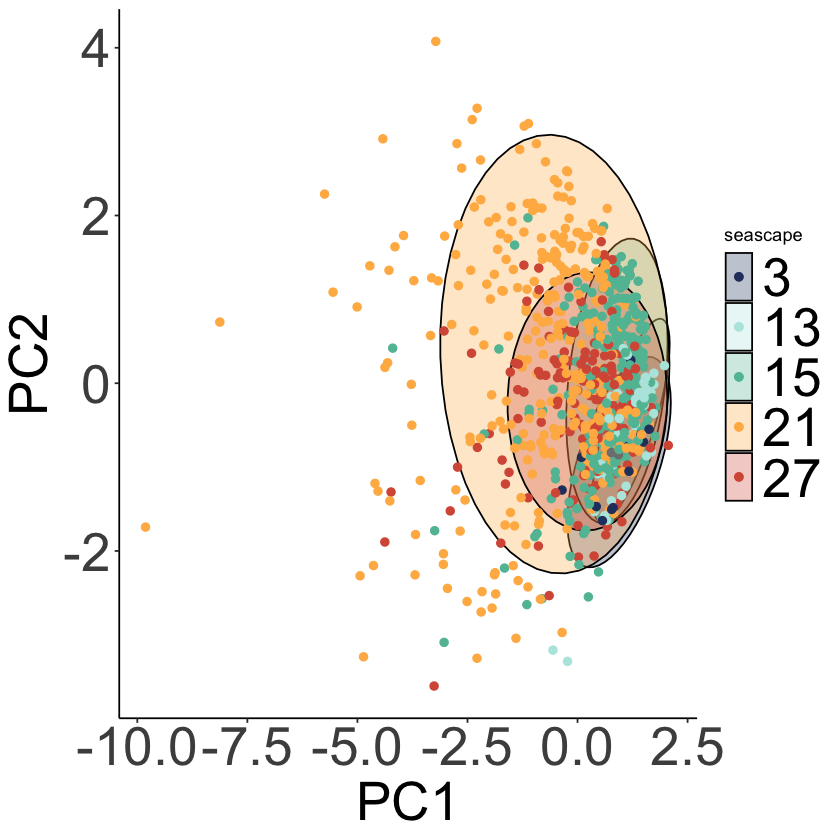

Warning message:
"Removed 236 rows containing missing values (`geom_point()`)."


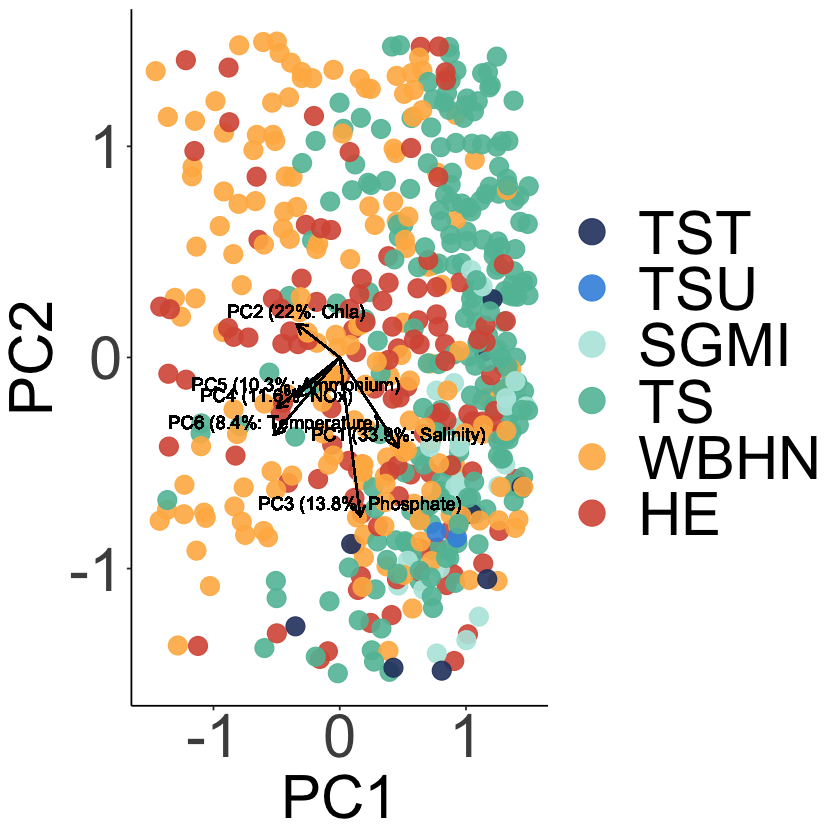

In [6]:
# Create PC plots with parameter distributions per seascape class with vectors  

library(ggalt)

# Perform principal component analysis on the count data

# for hydrography
sel_vars <- c(
  "X8.day.seascapes",
  "salinity",
  "Avg.chl.a..ug.L.",
  "PO4...uM.",
  "NO3.NO2..uM.",
  "NH4...uM.",
  "temp..degC.")

# for taxonomy
# sel_vars <- c("X8.day.seascapes",
#               "Acantharea",
#               "Copepods",
#               "Echinoderms",
#               "Jellies",
#               "Larvaceans",
#               "Polychaets",
#               "Chaetognaths",
#               "Pteropods")

# sel_vars <- c("X8.day.seascapes",
#               "Ceratium",
#               "Chaetoceros",
#               "Chain2",
#               "Chain3",
#               "Guinardia",
#               "Neocalyptrella",
#               "Tricho")

# sel_vars <- c("X8.day.seascapes",
#               "Acantharea",
#               "Copepods",
#               "Echinoderms",
#               "Jellies",
#               "Larvaceans",
#               "Polychaets",
#               "Chaetognaths",
#               "Pteropods",
#               "Ceratium",
#               "Chaetoceros",
#               "Chain2",
#               "Chain3",
#               "Guinardia",
#               "Neocalyptrella",
#               "Tricho")

# filter out rows with NA values in column seascapes
# df_filtered_pca <- taxa_meta[complete.cases(taxa_meta$X8.day.seascapes), ]
df_filtered_pca <- taxa_meta[complete.cases(taxa_meta[, sel_vars]), ]
# exclude_seascapes <- c(5, 7, 11)
exclude_seascapes <- 0
filt_df_pca <- df_filtered_pca[!df_filtered_pca$X8.day.seascapes %in%
                                 exclude_seascapes, sel_vars]

# Select numeric columns in filt_df_pca
numeric_cols <- sapply(filt_df_pca, is.numeric)
# Identify numeric columns except the first one
numeric_cols <- 2:ncol(filt_df_pca)

# Transform numeric columns to log scale
filt_df_pca[numeric_cols] <- lapply(filt_df_pca[numeric_cols], function(x) log(x + 1))


# pca <- prcomp(filt_df_pca[, c("salinity", "Avg.chl.a..ug.L.", "PO4...uM.", "NO3.NO2..uM.")], scale. = TRUE)
pca <- prcomp(filt_df_pca[, -1], scale. = TRUE)

# Extract PC1 and PC2 scores for each sampling event
# pc_scores <- data.frame(seascape = df_subset$X8.day.seascapes, # for taxonomic analysis 
pc_scores <- data.frame(seascape = as.character(filt_df_pca$X8.day.seascapes), # for hydrography
                        PC1 = pca$x[, 1], 
                        PC2 = pca$x[, 2])

# Create the plot
pc_scores$seascape <- factor(pc_scores$seascape, levels = c("3", "13", "15", "21", "27"))
bb <- ggplot(pc_scores, aes(x = PC1, y = PC2, color = seascape)) + 
  geom_point() +
  labs(x = "PC1", y = "PC2", color = "Seascape") 

# add circle around cluster of data points
# custom_colors_pca <- custom_pal_hex[c(1, 5, 6, 7, 8)]
custom_colors_pca <- custom_colors

yy <- ggplot(pc_scores, aes(x = PC1, y = PC2, color = seascape)) + 
  geom_point() +
  stat_ellipse(aes(fill = seascape), level = 0.90, geom = "polygon", alpha = 0.3, color = "black") +
  scale_color_manual(values = custom_colors_pca) +
  scale_fill_manual(values = custom_colors_pca) +
  theme_classic() +
  # xlim(-2,2) +
  # ylim(-2,2) +
  # xlim(-1,1) +
  # ylim(-1,1) +
  geom_point(size=2) +
  guides(colour = guide_legend(override.aes = list(size=2))) + 
  theme(axis.text.x = element_text(size = 32),  # Set X-axis label font size
        axis.text.y = element_text(size = 32)) +
  theme(axis.title.x = element_text(size = 32),
        axis.title.y = element_text(size = 32)) +
  theme(legend.text = element_text(size = 32))

yy

################################################################################################
# # Create PCA with eigenvectors
# Extract principal component scores
pc_scores2 <- pca$x
# Extract eigenvectors
eigenvectors <- pca$rotation
# Calculate the percentage variance explained by each principal component
total_variance <- sum(pca$sdev^2)
pc_var_percent <- round(100 * (pca$sdev^2) / total_variance, 1)

# Convert X8.day.seascapes to a factor
filt_df_pca$X8.day.seascapes <- as.factor(filt_df_pca$X8.day.seascapes)

# # For hydrography
qq <- ggplot(filt_df_pca, aes(x = pc_scores2[,1], y = pc_scores2[,2], color = X8.day.seascapes)) +
  geom_point(size = 5, alpha = 0.9) +
  scale_color_manual(values = custom_colors_pca, labels = seascape_labels) +
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 1], yend = eigenvectors[2, 1]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") +  # Add vector for PC1
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 2], yend = eigenvectors[2, 2]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") + # Add vector for PC2
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 3], yend = eigenvectors[2, 3]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") + # Add vector for PC3
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 4], yend = eigenvectors[2, 4]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") + # Add vector for PC4
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 5], yend = eigenvectors[2, 5]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") + # Add vector for PC5
  geom_segment(aes(x = 0, y = 0, xend = eigenvectors[1, 6], yend = eigenvectors[2, 6]),
               arrow = arrow(length = unit(0.1, "inches")), color = "black") + # Add vector for PC6
  geom_text(aes(x = eigenvectors[1, 1], y = eigenvectors[2, 1], 
                label = paste("PC1 (", pc_var_percent[1], "%: Salinity)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC1
  geom_text(aes(x = eigenvectors[1, 2], y = eigenvectors[2, 2], 
                label = paste("PC2 (", pc_var_percent[2], "%: Chla)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC2
  geom_text(aes(x = eigenvectors[1, 3], y = eigenvectors[2, 3], 
                label = paste("PC3 (", pc_var_percent[3], "%: Phosphate)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC3
  geom_text(aes(x = eigenvectors[1, 4], y = eigenvectors[2, 4], 
                label = paste("PC4 (", pc_var_percent[4], "%: NOx)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC4
  geom_text(aes(x = eigenvectors[1, 5], y = eigenvectors[2, 5], 
                label = paste("PC5 (", pc_var_percent[5], "%: Ammonium)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC5
  geom_text(aes(x = eigenvectors[1, 6], y = eigenvectors[2, 6], 
                label = paste("PC6 (", pc_var_percent[6], "%: Temperature)", sep = "")),
            vjust = -0.5, hjust = 0.5, color = "black") +  # Add label for PC6
  labs(x = "PC1", y = "PC2", color = "Seascape class") +
  xlim(-1.5, 1.5) +
  ylim(-1.5, 1.5) +
  guides(colour = guide_legend(title = NULL, override.aes = list(size=7))) + 
  theme_classic() +
  theme(axis.text.x = element_text(size = font_size),  # Set X-axis label font size
        axis.text.y = element_text(size = font_size)) +
  theme(axis.title.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size)) +
  theme(legend.text = element_text(size = font_size)) +
  theme(legend.title = element_text(size = font_size))
qq

ggsave("seascape_pca_hydro.jpeg", plot = qq, width = 14, height = 9, device = "jpeg")

Warning message:
"package 'ggOceanMaps' was built under R version 4.2.3"
ggOceanMaps: Setting data download folder to a temporary folder
/var/folders/pj/01bgh26153x4c6rjpm45t1hrt405dy/T//RtmpYiVEb3. This
means that any downloaded map data need to be downloaded again when you
restart R. To avoid this problem, change the default path to a
permanent folder on your computer. Add following lines to your
.Rprofile file: {.ggOceanMapsenv <- new.env(); .ggOceanMapsenv$datapath
<- 'YourCustomPath'}. You can use usethis::edit_r_profile() to edit the
file. '~/ggOceanMapsLargeData' would make it in a writable folder on
most operating systems.



[1] 18461.53


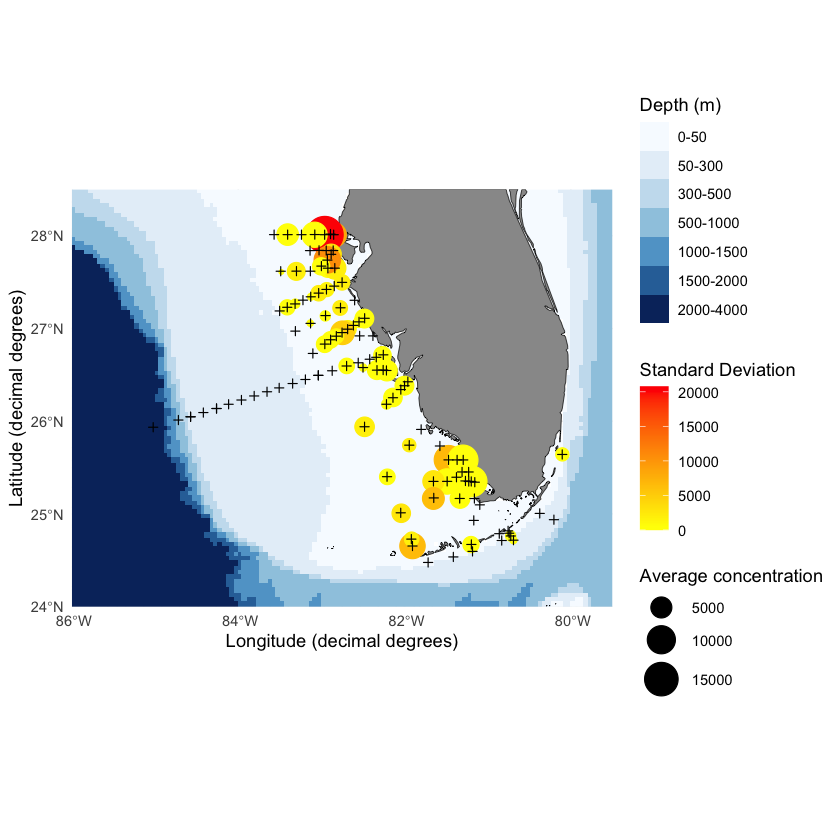

In [7]:
# Map overall mean concentration values of selected taxa per station

library(ggOceanMaps)

# List of class names
# Acantharea, Chaetognaths, Ostracods, Copepods, Decapods, Echinoderms, Jellies, Larvaceans, Polychaets, Pteropods, pellets
# Centric, Ceratium, Chaetoceros, Chain2, Chain3, Guinardia, Neocalyptrella, Noctiluca, Tricho
selected_class <- "pellets"

taxa_meta_concentration <- taxa_meta %>%
  mutate(across(all_of(selected_class), ~ . / total_vol_sampled * 1e6)) %>%
  select(Station, dec_lat, dec_lon, year, month, date, total_vol_sampled, all_of(selected_class)) %>%
  filter(!is.na(total_vol_sampled)) 

# Exclude rows where selected_class equals 0
taxa_meta_concentration <- taxa_meta_concentration %>%
  filter(get(selected_class) > 0)

# Use this to select a specific time period
# taxa_meta_concentration <- taxa_meta_concentration %>% filter(year == 2023 & month == 7)

# Compute mean concentration of selected groups per station
taxa_concentration_avg_station <- taxa_meta_concentration %>%
  group_by(Station) %>%
  summarise(longitude_station = mean(dec_lon, na.rm = TRUE),
            latitude_station = mean(dec_lat, na.rm = TRUE),
            sel_taxa_mean_station = mean(get(selected_class), na.rm = TRUE),
            sel_taxa_sd_station = sd(get(selected_class), na.rm = TRUE))

# Get station coordinates
path_sfer_list <- "~/Library/CloudStorage/GoogleDrive-enriquemontes01@gmail.com/My Drive/GDrive/proposals/2022_02_MultiStressor_NOAA/module_1"
sfer_curated <- list.files(path_sfer_list, pattern = "sfer_stations_curated.csv", full.names = TRUE)
sfer_sta_list <- read.csv(sfer_curated, header = TRUE)

# # Map with bathymetry
  # Overlay color-scaled dots
dt_station <- data.frame(
  lon_station = taxa_concentration_avg_station$longitude_station, 
  lat_station = taxa_concentration_avg_station$latitude_station, 
  mean_param_station = taxa_concentration_avg_station$sel_taxa_mean_station,
  sd_param_station = taxa_concentration_avg_station$sel_taxa_sd_station)

# Replace NA by zeros
dt_station <- dt_station %>%
  mutate(sd_param_station = replace_na(sd_param_station, 0))

# Add station markers
station_markers <- sfer_sta_list %>% filter(station_class %in% "C")
    
concentration_map_station <- basemap(limits = c(-86, -79.5, 24, 28.5), bathymetry = TRUE) +
  geom_point(data = dt_station, aes(x = lon_station, 
                                    y = lat_station, 
                                    size = mean_param_station, 
                                    color = sd_param_station)) +
  scale_color_gradient(low = "yellow", high = "red", na.value = NA, name = "Standard Deviation") +
  geom_point(data = station_markers, aes(x = mean_lon, y = mean_lat), color = "black", shape = 3, size = 1.5) +
  scale_size_continuous(name = "Average concentration", 
                        # breaks = c(250, 500, 750),
                        range = c(1, 10),
                        guide = guide_legend(override.aes = list(color = "black", fill = "white"))) +
  theme_minimal() 

# Optionally, save each map as an image
# ggsave(paste0("conc_map_station_", selected_class, ".png"), plot = concentration_map_station, width = 8, height = 6)
# ggsave(paste0("conc_map_station_", selected_class, ".svg"), plot = concentration_map_station, width = 8, height = 6, device = "svg")
print(concentration_map_station)

write.csv(dt_station, paste0("df_",selected_class,".csv"), row.names = FALSE)
print(max(dt_station$mean_param_station))